## Building GPT from Scatch

In [1]:
# downloading toy dataset 
import os
import requests

WORK_dir = '/n/projects/kc2819/projects/ChotaLLM'
DATA_dir =  os.path.join(WORK_dir, 'data')
SRC_dir = os.path.join(WORK_dir, 'src')

input_file_path = os.path.join(DATA_dir,'shakespeare', 'input.txt')
if not os.path.exists(input_file_path):
    data_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
    with open(input_file_path, 'w', encoding='utf-8') as f:
        f.write(requests.get(data_url).text)

with open(input_file_path, 'r', encoding='utf-8') as f:
    text = f.read()
    print(text[:1000])
    print('text length:', len(text))


First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



## simple index based tokenization

* get unique characters --> vocabulary 
* create a simple tokenizer to convert a string to number with vocabulary.
* Todo that useing simple encoder decoder kind fo character mapping.

In [2]:
class simpleTokenizer:

    '''
    Simple tokenizer that encode decode character level tokenization.
    Alternatives could be google sentencepiece, huggingface tokenizers, openai Tiktoken library.
    
    '''

    def __init__(self,text):
        self.unique_chars = sorted(list(set(text)))
        self.vocab_size = len(self.unique_chars)
        # strign to index mapping
        self.str_to_idx = {chr: idx for idx,chr in enumerate(self.unique_chars)}
        # index to string mapping
        self.idx_to_str = {idx: chr for idx,chr in enumerate(self.unique_chars)}

        # adding padding and unknown token
        self.str_to_idx['<PAD>'] = self.vocab_size
        self.idx_to_str[self.vocab_size] = '<PAD>'
        self.unique_chars.append('<PAD>')

        self.str_to_idx['<UNK>'] = self.vocab_size + 1
        self.idx_to_str[self.vocab_size + 1] = '<UNK>'
        self.unique_chars.append('<UNK>')

        self.vocab_size += 2

    def encode(self, text):
        '''
        this function takes a string and look up in the string to index mapping, and return the list of indices.
        '''
 
        return [self.str_to_idx[chr] if chr in self.unique_chars else self.str_to_idx['<UNK>'] for chr in text]
        
        
    def decode(self, indices):
        '''
        this function takes a list of indices and look up in the index to string mapping, and return the string.
        '''
        return ''.join([self.idx_to_str[idx] for idx in indices]) 
    
    def get_vocab_size(self):
        return self.vocab_size
    
    def get_unique_chars(self):
        return self.unique_chars


In [3]:
tokenizer = simpleTokenizer(text)
print('vocab size:', tokenizer.get_vocab_size())
print('unique chars:', ''.join(tokenizer.get_unique_chars()))

vocab size: 67
unique chars: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz<PAD><UNK>


In [4]:
# test cast
encoded_text = tokenizer.encode('hello, IM Bhuvan, asdflasdf &&*&&)))())')
decoded_text = tokenizer.decode(encoded_text)
print('encoded text:', encoded_text)
print('decoded text:', decoded_text)

encoded text: [46, 43, 50, 50, 53, 6, 1, 21, 25, 1, 14, 46, 59, 60, 39, 52, 6, 1, 39, 57, 42, 44, 50, 39, 57, 42, 44, 1, 4, 4, 66, 4, 4, 66, 66, 66, 66, 66, 66]
decoded text: hello, IM Bhuvan, asdflasdf &&<UNK>&&<UNK><UNK><UNK><UNK><UNK><UNK>


### tokenizing data


In [5]:
import torch

In [6]:
data = torch.tensor(tokenizer.encode(text),dtype = torch.long)
print('encoded data shape, type \n' ,data.shape,data.dtype)
print( 'encoded data: \n', data[:100])
print('decoded data: \n', tokenizer.decode(data[:100].tolist()))

encoded data shape, type 
 torch.Size([1115394]) torch.int64
encoded data: 
 tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])
decoded data: 
 First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


### data splits

In [7]:
n = int(0.9 * len(data))
train_data, val_data = data[:n], data[n:]

block size or context length is a small chunk of data in a a sequencial fashion. When we feed this block of string into a transformer, with respect to string{1 -> n} n+1th character is the target for the tranfomer. From the lecture chunk_size or block_size = 8.

In [ ]:
block_size = 8
x = train_data[:block_size]  # block with 0 -> block_size for the training input 
y = train_data[1:block_size+1] # block with 1 -> block_size+1 for the training target, shifted by 1 from the input

print('x: \n', x )
print('shape of x:\n', x.shape)

print('y: \n', y)
print('shape of y:\n', y.shape)

for i in range(block_size):
    context = x[:i+1]
    target = y[i]
    print(f'for context:{context},target is {target} \n')
    


x: 
 tensor([18, 47, 56, 57, 58,  1, 15, 47])
shape of x:
 torch.Size([8])
y: 
 tensor([47, 56, 57, 58,  1, 15, 47, 58])
shape of y:
 torch.Size([8])
for context:tensor([18]),target is 47 

for context:tensor([18, 47]),target is 56 

for context:tensor([18, 47, 56]),target is 57 

for context:tensor([18, 47, 56, 57]),target is 58 

for context:tensor([18, 47, 56, 57, 58]),target is 1 

for context:tensor([18, 47, 56, 57, 58,  1]),target is 15 

for context:tensor([18, 47, 56, 57, 58,  1, 15]),target is 47 

for context:tensor([18, 47, 56, 57, 58,  1, 15, 47]),target is 58 



In [ ]:
# batching the data

torch.manual_seed(1337)
block_size = 8 # this is the time dimension of the data (sequence length)
batch_size = 4 # number of sequences in a single batch

def get_batch(split):
    data  = train_data if split == 'train' else val_data
    start_idx = torch.randint(0, data.size(0) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in start_idx]) # (batch_size, block_size) expected shape and expected in tuple of tensors or list of tensors
    y = torch.stack([data[i+1:i+block_size+1] for i in start_idx])
    return x,y

x,y = get_batch('train')

print('x: \n', x )
print('shape of x:\n', x.shape)

print('y: \n', y)
print('shape of y:\n', y.shape)


for b in range(batch_size):
    for i in range(block_size):
        context = x[b,:i+1]
        target = y[b,i]
        print(f'for context:{context},target is {target} \n')

x: 
 tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
shape of x:
 torch.Size([4, 8])
y: 
 tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
shape of y:
 torch.Size([4, 8])
for context:tensor([24]),target is 43 

for context:tensor([24, 43]),target is 58 

for context:tensor([24, 43, 58]),target is 5 

for context:tensor([24, 43, 58,  5]),target is 57 

for context:tensor([24, 43, 58,  5, 57]),target is 1 

for context:tensor([24, 43, 58,  5, 57,  1]),target is 46 

for context:tensor([24, 43, 58,  5, 57,  1, 46]),target is 43 

for context:tensor([24, 43, 58,  5, 57,  1, 46, 43]),target is 39 

for context:tensor([44]),target is 53 

for context:tensor([44, 53]),target is 56 

for context:tensor([44, 53, 56]),target is 1 

for context:tensor([44, 53,

## network construction


In [ ]:
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
torch.manual_seed(1337)

vocab_size = tokenizer.get_vocab_size()


def plotwegihts(layer):
    '''
    function to plot the weights of the layer
    '''
    fig, axs = plt.subplots(1,2,figsize=(12,4))
    axs[0].imshow(layer.weight.data.cpu().numpy())
    axs[0].set_title('weights')
    axs[1].hist(layer.weight.data.cpu().numpy().flatten(), bins=100)
    axs[1].set_title('weights distribution')
    fig.show()

In [ ]:
emb = nn.Embedding(vocab_size, vocab_size)

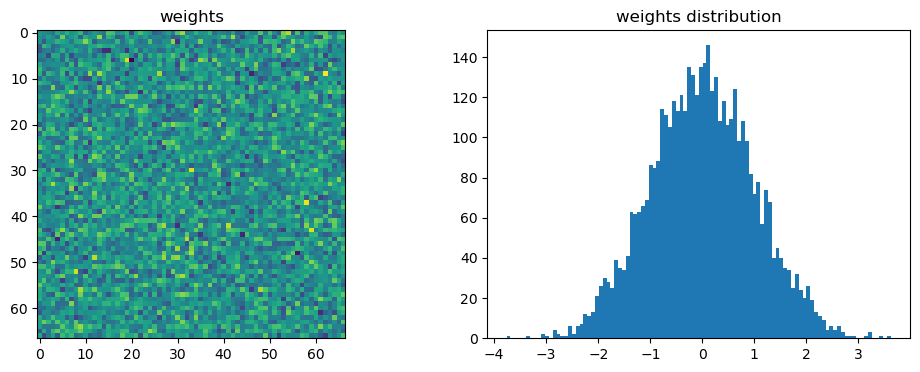

In [ ]:
plotwegihts(emb)

In [ ]:
class BigramLanguageModel(nn.Module):
    
    def __init__(self,vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self,idx,targets = None):

        logits = self.token_embedding_table(idx) # --> (B,T,C) - (batch_size, block_size, vocab_size) 
        # loss = F.cross_entropy(logits, targets) # --> (batch_size, block_size) expected target shape but this will run into error because of pytorch expectation of the
        #                                         # multidimentional is (B*T,C) not (B,T,C)
        # so converting logits --> (B*T,C) and targets --> (B*T,) 
        # refer: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

        if targets is None:
            loss = None
        else:
            B,T,C = logits.shape
            logits = logits.view(B*T,C)
            
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss
    
    def generate(self,idx, max_new_tokens = 100):
        '''
        function to generate new tokens based on the given context
        idx : tensor of shape (B,T) - batch_size, block_size
        returns: tensor of shape (B,T) - batch_size, block_size
        '''

        for _ in range(max_new_tokens):
            logits, _ = self.forward(idx)
            # taking only last layer logits
            logits = logits[:,-1,:] # (B,C)
            # applying softmax to get the probabilities
            probs = F.softmax(logits, dim = -1) # (B,C) ---> in this bigram model, we care only for the last token but the attention models will take all the previous tokens into account 
            # sampling from the probabilities
            idx_next = torch.multinomial(probs, num_samples = 1) # (B,1) # refer (2) below
            # append the sampled index to the running sequence
            idx = torch.cat([idx,idx_next],dim = 1)
        return idx


In [ ]:
model = BigramLanguageModel(vocab_size)
logits, loss = model(x,y)
print('logits shape:', logits.shape)
print(f'expected loss: {-1 * np.log(1/vocab_size)}, loss:{loss}') # ---> expected loss is prob of random token selection from vocab list

idx = torch.zeros((1,1),dtype = torch.long)
new_tokens = model.generate(idx, max_new_tokens = 100).tolist()
print('new tokens:', tokenizer.decode(new_tokens[0])) 


logits shape: torch.Size([32, 67])
expected loss: 4.204692619390966, loss:4.766834735870361
new tokens: 
GlDAXeuFIV?q-;3HbqSmm<UNK>hTAMsE$&<PAD>Vf,-ja'LZSW:jydb<UNK>cTZfHzKLSkZY!brQVf!pr:oT; zB<UNK>eBRGkyG&DeLFPl?R'ix<UNK>!uN


In [ ]:
# (2) I am applyin the softmax to logits last index to see the probs of the tokens
# as this is part of the generation logic process

probs = F.softmax(logits.view(batch_size, block_size, vocab_size)[:,-1,:], dim=-1)
print(probs.shape)
idx_probs = torch.multinomial(probs, num_samples=1) #(batch_size, 1) --> multinomial sampling is better than argmax as it gives the distribution of the tokens in the vocab
tokenizer.decode(idx_probs.flatten().tolist()) 

torch.Size([4, 67])


':SQK'

In [ ]:
# helper functions to look into the model

def plot_loss(loss):
    fig, ax = plt.subplots(1,1,figsize=(12,4))
    ax.plot(loss)
    ax.set_title('loss')
    fig.show()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:00<00:00, 16.41it/s]


step:999, loss:3.7853264808654785


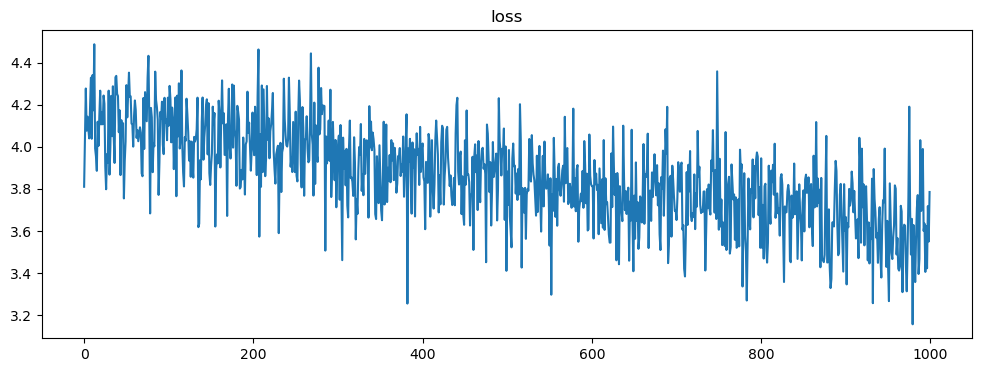

In [ ]:
## training the bigram model  
# def get_batch(split):
#     data  = train_data if split == 'train' else val_data
#     start_idx = torch.randint(0, data.size(0) - block_size, (batch_size,))
#     x = torch.stack([data[i:i+block_size] for i in start_idx]) # (batch_size, block_size) expected shape and expected in tuple of tensors or list of tensors
#     y = torch.stack([data[i+1:i+block_size+1] for i in start_idx])
#     return x,y

optim = torch.optim.AdamW(model.parameters(), lr = 1e-3)
loss_track = []
for step in tqdm(range(1000)):
    x,y = get_batch('train')
    _, loss = model(x,y)
    optim.zero_grad(set_to_none=True)
    loss.backward()
    optim.step()
    loss_track.append(loss.item())

print(f'step:{step}, loss:{loss.item()}')
    
    
plot_loss(loss_track)

In [ ]:
idx = torch.zeros((1,1),dtype = torch.long)
new_tokens = model.generate(idx, max_new_tokens = 100).tolist()
print('new tokens:', tokenizer.decode(new_tokens[0])) 

new tokens: 
lIXVI tw?
CqMKK<PAD>aYcatGxSibLg,g<UNK>caOqT<UNK>STLNd!t'sehwXWattc'n
'T;mrNQi
yw,dmX?iaJ;OdJ x ClCVhl,ZrdMNFh'U
